In [12]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

np.random.seed(0)
torch.manual_seed(0)

# embed reber文法
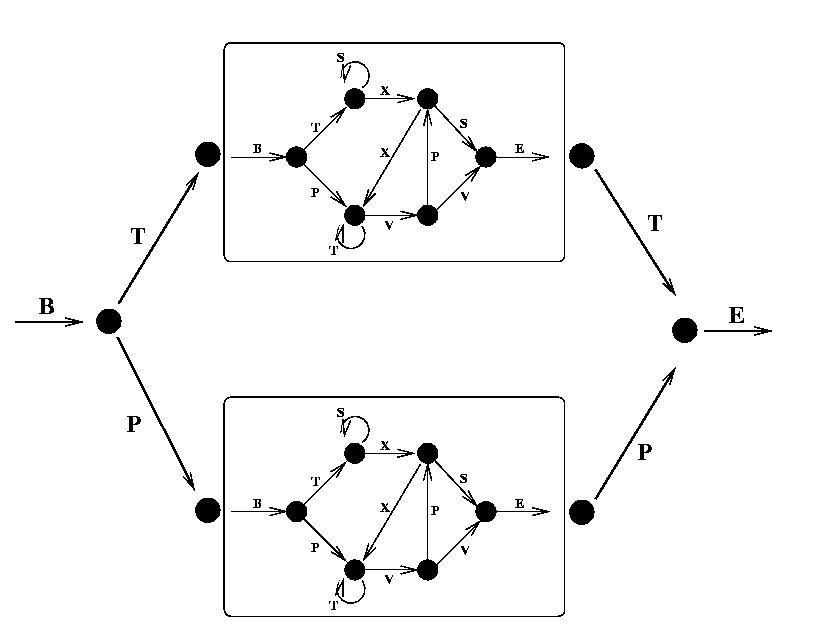
识别embed reber文法需要可以记忆长期依赖的模型

生成embed reber串可以在之前的生成模块两边随机生成T或P的对

In [13]:
# 生成embed reber语言
def EMBED_REBER(n, lenth=None):
    N = 0
    R = []
    while N < n:
        r, s = "B", 0 # 初始文字，状态
        transfer_map = {
            0 : [("T", 1), ("P", 2)],
            1 : [("S", 1), ("X", 3)],
            2 : [("T", 2), ("V", 4)],
            3 : [("X", 2), ("S", 5)],
            4 : [("P", 3), ("V", 5)]
        }

        while s != 5 :
            if np.random.rand() > 0.5:
                next_state = transfer_map[s][0]
            else:
                next_state = transfer_map[s][1]
            r += next_state[0]
            s = next_state[1]

        r += "E"
        
        # 两侧添加
        if np.random.rand() > 0.5:
            r = "BT" + r + "TE"
        else:
            r = "BP" + r + "PE"
        
        if lenth:
            if len(r) == lenth:
                R.append(r)
                N += 1
        else:
            R.append(r)
            N += 1
    

    
    return R

train_data = EMBED_REBER(256, 14)
print(train_data)

['BTBTXXTTVPSETE', 'BPBTXXTTVPSEPE', 'BTBTSSSXXVVETE', 'BTBPVPXTTVVETE', 'BTBTSSXXVPSETE', 'BPBTSXXTTVVEPE', 'BTBPTTVPXVVETE', 'BPBTXXTTVPSEPE', 'BPBTSSSSSXSEPE', 'BTBTSSSXXVVETE', 'BPBPTVPXTVVEPE', 'BPBPVPXTTVVEPE', 'BPBPTTTTVPSEPE', 'BTBTXXTTVPSETE', 'BTBTSSSXXVVETE', 'BPBTSSSXXVVEPE', 'BPBTSSSSSXSEPE', 'BTBPTTTTTVVETE', 'BTBTXXTTVPSETE', 'BPBPVPXTTVVEPE', 'BPBPVPXTTVVEPE', 'BTBTSSXXVPSETE', 'BPBPTTTTVPSEPE', 'BPBPTTVPXVVEPE', 'BPBPTTTTVPSEPE', 'BTBTXXVPXVVETE', 'BPBPVPXTVPSEPE', 'BPBTSXXTVPSEPE', 'BTBTSSXXTVVETE', 'BPBPVPXTVPSEPE', 'BTBTSSXXTVVETE', 'BPBTXXTTTVVEPE', 'BTBTXXTTVPSETE', 'BTBTSXXTTVVETE', 'BTBTSSSXXVVETE', 'BPBPTVPXTVVEPE', 'BTBPTTVPXVVETE', 'BTBTXXTTVPSETE', 'BPBTXXTTTVVEPE', 'BPBPVPXTVPSEPE', 'BPBTXXVPXVVEPE', 'BPBPVPXTVPSEPE', 'BTBPTVPXTVVETE', 'BTBPVPXTVPSETE', 'BTBPTTTTTVVETE', 'BTBTXXTTTVVETE', 'BPBTXXVPXVVEPE', 'BPBTSXXTTVVEPE', 'BPBPVPXTVPSEPE', 'BPBPTTTTVPSEPE', 'BTBPTTTTVPSETE', 'BPBTXXVPXVVEPE', 'BPBTSXXTVPSEPE', 'BPBPTTTTVPSEPE', 'BPBTSSSXXVVEPE', 'BTBTSXXT

In [14]:
char_list = list("BTPSXVE")
char_num  = len(char_list)
char_map  = {c : char_list.index(c) for c in char_list}
char_map

{'B': 0, 'T': 1, 'P': 2, 'S': 3, 'X': 4, 'V': 5, 'E': 6}

In [15]:
# 数据生成器，用于读取批量数据
# 每个序列的前 L-1 位作为输入，后 L-1个作为监督信号
def data_iter(batch_size, data):
    # 数据大小
    data_num = len(data)
    seq_num  = len(data[0])
    char_num = 7
    # 随机排列
    permutation = np.arange(data_num)
    np.random.shuffle(permutation)
    permutation = permutation.tolist()
    # 每次取 batch_size 个
    for i in range(0, data_num, batch_size):
        # 每个 batch 的下标
        indices = permutation[i:i+batch_size]
        
        # 按照时间顺序变换
        batch_n_list = [] # 得到每一个字符对应的数字
        batch_n_advisor_list = [] # 监督信号
        for j in indices:
            # 对batch中下标为j的字符串数字化
            n_list = []
            for k in data[j]:
                # 获取该字符对应的数字
                n_list.append(char_map[k])
            
            batch_n_list.append(n_list[:-1])
            batch_n_advisor_list.append(n_list[1:])

        # 将其传入one_hot函数，得到(batch*seq*char)的tensor
        batch_seq_one_hot = F.one_hot(torch.tensor(batch_n_list), char_num)
        
        # 改为seq first的tensor，转置前两维
        seq_batch_one_hot = batch_seq_one_hot.transpose(0, 1)
        
        # advisor的tensor(batch*seq*char)
        batch_seq_advisor = torch.tensor(batch_n_advisor_list)
        seq_batch_advisor = batch_seq_advisor.transpose(0, 1) # 转置
        
        yield seq_batch_one_hot, seq_batch_advisor
    
data_iter_ = data_iter(5, train_data)
for _ in range(1):
    data = next(data_iter_)
    print(data)

(tensor([[[1, 0, 0, 0, 0, 0, 0],
         [1, 0, 0, 0, 0, 0, 0],
         [1, 0, 0, 0, 0, 0, 0],
         [1, 0, 0, 0, 0, 0, 0],
         [1, 0, 0, 0, 0, 0, 0]],

        [[0, 0, 1, 0, 0, 0, 0],
         [0, 0, 1, 0, 0, 0, 0],
         [0, 1, 0, 0, 0, 0, 0],
         [0, 0, 1, 0, 0, 0, 0],
         [0, 1, 0, 0, 0, 0, 0]],

        [[1, 0, 0, 0, 0, 0, 0],
         [1, 0, 0, 0, 0, 0, 0],
         [1, 0, 0, 0, 0, 0, 0],
         [1, 0, 0, 0, 0, 0, 0],
         [1, 0, 0, 0, 0, 0, 0]],

        [[0, 0, 1, 0, 0, 0, 0],
         [0, 1, 0, 0, 0, 0, 0],
         [0, 1, 0, 0, 0, 0, 0],
         [0, 1, 0, 0, 0, 0, 0],
         [0, 0, 1, 0, 0, 0, 0]],

        [[0, 1, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 1, 0, 0],
         [0, 0, 0, 1, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0],
         [0, 1, 0, 0, 0, 0, 0]],

        [[0, 1, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 1, 0, 0],
         [0, 0, 0, 1, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0],
         [0, 1, 0, 0, 0, 0, 0]],

        [[0, 0, 0, 0, 0, 1,

In [16]:
class ReberLSTM(nn.Module):
    def __init__(self):
        super().__init__()
        
        # parameters
        char_num = 7
        
        # layers
        self.input_hidden_layer = nn.LSTM(input_size=char_num, hidden_size=10, bias=False)
        self.output_layer = nn.Linear(in_features=10, out_features=char_num, bias=False)
        
    def forward(self, input):
        hidden_output, h_n = self.input_hidden_layer(input)
        output = self.output_layer(hidden_output)
        
        return output

In [17]:
myNN = ReberLSTM()

# 训练阶段
epoch_num  = 40000
batch_size = 16
learning_rate = 1e-3

# 生成优化器
optimizer = optim.SGD(myNN.parameters(), lr=learning_rate)

for epoch in range(epoch_num):
    for INPUT, TARGET in data_iter(batch_size, train_data):
        # forward
        output = myNN(INPUT.float())
        Loss = F.cross_entropy(output.reshape(-1, 7), TARGET.reshape(-1))
        
        # update
        optimizer.zero_grad()
        Loss.backward()
        optimizer.step()

    if epoch % 2000 == 0:
        print(" for epoch %10d , Loss is %s" % (epoch, Loss.item()))

 for epoch          0 , Loss is 1.9548033475875854
 for epoch       2000 , Loss is 1.8906290531158447
 for epoch       4000 , Loss is 1.734405755996704
 for epoch       6000 , Loss is 1.465674877166748
 for epoch       8000 , Loss is 1.128794550895691
 for epoch      10000 , Loss is 0.8521116971969604
 for epoch      12000 , Loss is 0.684528112411499
 for epoch      14000 , Loss is 0.5828148126602173
 for epoch      16000 , Loss is 0.5073099732398987
 for epoch      18000 , Loss is 0.4440280795097351
 for epoch      20000 , Loss is 0.4292106330394745
 for epoch      22000 , Loss is 0.40830039978027344
 for epoch      24000 , Loss is 0.3769316077232361
 for epoch      26000 , Loss is 0.3645888566970825
 for epoch      28000 , Loss is 0.3780266046524048
 for epoch      30000 , Loss is 0.3557244837284088
 for epoch      32000 , Loss is 0.3334082067012787
 for epoch      34000 , Loss is 0.34226587414741516
 for epoch      36000 , Loss is 0.33130741119384766
 for epoch      38000 , Loss is 

In [20]:
# 预测一个序列
seq = 'BPBTXXTTVPSEPE'
# 转为 seq_one_hot
n_list = []
for i in seq:
    # 获取该字符对应的数字
    n_list.append(char_map[i])
seq_one_hot = F.one_hot(torch.tensor(n_list))
test_output = myNN(seq_one_hot[:-1].unsqueeze(1).float())
test_output

tensor([[[  0.1752,   5.4207,   5.5639,  -3.7640,  -3.0423,  -1.1156,  -3.6353]],

        [[  5.7254,   1.8105,  -0.9432,  -1.4328,   0.0811,  -0.9515,  -3.5621]],

        [[ -1.0067,   4.9332,   4.7987,  -0.4179,  -0.5712,  -0.3460,  -7.5094]],

        [[  1.5289,  -1.3405,  -1.2662,   5.0093,   4.7933,  -0.1269,  -7.7689]],

        [[ -0.8584,   1.5755,  -1.3819,   2.5048,   6.0253,   1.5062,  -8.9626]],

        [[ -1.4433,   5.9936,  -0.3196,  -2.2986,   2.7568,   4.8076,  -9.8731]],

        [[ -3.2112,   8.3764,   2.3120,  -3.9890,   0.3093,   5.8915, -10.5837]],

        [[ -4.8337,   7.0537,   2.1827,  -2.7873,  -0.1197,   6.3740,  -8.8994]],

        [[ -9.2790,   1.7478,   9.5693,  -0.9397,  -1.9602,   3.2924,  -3.9688]],

        [[ -5.5410,  -3.6882,  -2.6714,   6.3192,   3.0562,   1.5940,   0.9167]],

        [[ -4.7384,  -2.5396,   0.7886,   1.1844,  -1.7159,   0.8428,   5.4067]],

        [[ -4.9835,   4.5095,   7.1402,  -3.9684,  -5.1194,  -0.3571,   1.7751]],

    

当输入第二位是P的时候，倒数第二位的输出是P的概率大。

In [21]:
# 预测一个序列
seq = 'BTBTSSSXXVVETE'
# 转为 seq_one_hot
n_list = []
for i in seq:
    # 获取该字符对应的数字
    n_list.append(char_map[i])
seq_one_hot = F.one_hot(torch.tensor(n_list))
test_output = myNN(seq_one_hot[:-1].unsqueeze(1).float())
test_output

tensor([[[ 0.1752,  5.4207,  5.5639, -3.7640, -3.0423, -1.1156, -3.6353]],

        [[ 5.6729, -0.3451, -2.7417,  0.4560,  1.0183, -1.3840, -1.6948]],

        [[-1.3772,  4.6833,  4.5907, -0.4523, -0.5792, -0.3573, -6.6005]],

        [[ 1.6300, -1.7902, -2.1118,  5.2278,  4.8419, -0.3009, -6.6145]],

        [[ 0.4648, -3.8128, -3.5149,  7.4675,  6.3972, -1.0131, -5.0394]],

        [[-0.5773, -4.6519, -4.9228,  8.5415,  7.7752, -0.8830, -4.3560]],

        [[-2.4452, -3.3885, -4.2938,  8.1496,  7.8386, -0.7932, -4.4537]],

        [[-4.1047,  1.0638, -3.8039,  3.9245,  5.9701,  2.5496, -5.7881]],

        [[-7.3254,  2.3843, -2.7041,  2.2312,  1.7926,  6.4075, -3.8856]],

        [[-9.6391, -1.0459,  1.6402,  0.4471, -1.7953,  6.7993,  1.5194]],

        [[-4.4682, -3.4255,  0.4139,  1.3988, -1.6978, -0.8825,  7.7974]],

        [[-2.8598,  5.7088,  4.7404, -4.2420, -3.6867, -0.8134,  0.4342]],

        [[-0.0794, -0.2810, -0.3983, -2.0691, -3.1652, -0.8365,  6.7006]]],
       grad_

当输入第二位是T的时候，倒数第二位的输出是T的概率大。